In [17]:
import numpy as np
import pandas as pd

class FXTrading:
    def __init__(self, fx_rates, real_fx_rates):
        """
        Initialize the FXTrading simulation environment.

        Args:
            fx_rates (numpy array): Predicted FX rates (3, N)
            real_fx_rates (numpy array): Real FX rates (3, N)
        """
        self.Pre_fx_rates = fx_rates
        self.real_fx_rates = real_fx_rates
        self.day = 0
        self.start = len(fx_rates[0]) - 1  # Starting point in the time series

        self.initial_capital = np.array([1000, 1000, 1000], dtype=float)  # Initial capital for 3 currencies
        self.capital = np.array([1000, 1000, 1000], dtype=float)  # Current capital
        self.available_margin = self.capital  # Available margin

        self.leverage = np.array([5, 5, 5])  # Leverage for each currency (can be changed when opening positions)
        self.position_size = np.array([0, 0, 0], dtype=float)  # Current position size (positive=long, negative=short)
        self.position_value = np.array([0, 0, 0], dtype=float)  # Current position value
        self.floating_pnl = np.array([0, 0, 0], dtype=float)  # Current floating profit and loss
        self.now_price = np.array([
            real_fx_rates[0][self.start],
            real_fx_rates[1][self.start],
            real_fx_rates[2][self.start]
        ], dtype=float)  # Current market price
        self.entry_price = np.array([0, 0, 0], dtype=float)  # Entry price of the current position
        self.margin = 10  # Margin required per position

        self.model = None  # Placeholder for custom prediction model

    def check_liquidation(self, cap_num, maintenance_margin_ratio_threshold=0.3):
        """
        Check if the position should be liquidated (trigger forced liquidation).

        Args:
            cap_num (int): Index of the currency (0, 1, 2)
            maintenance_margin_ratio_threshold (float): Liquidation threshold (default 30%)

        Returns:
            bool: True if should liquidate, False otherwise
        """
        equity = self.capital[cap_num] + self.floating_pnl[cap_num]

        if equity / (self.margin * abs(self.position_size[cap_num])) < maintenance_margin_ratio_threshold:
            return True

        return False

    def close_position(self, cap_num, close_price):
        """
        Close the position and calculate realized PnL.

        Args:
            cap_num (int): Index of the currency
            close_price (float): Current market price

        Returns:
            float: Realized PnL
        """
        return (close_price - self.entry_price[cap_num]) * self.position_size[cap_num] * self.margin * self.leverage[cap_num] / close_price

    def predict_fx_rate(self, data): #Needs to be designed manually
        """
        Predict the next FX rate. User should implement their own model.

        Args:
            data (any): Input features for prediction.

        Returns:
            None: Updates self.Pre_fx_rates
        """
        # Random prediction example:
        a = np.random.choice(self.Pre_fx_rates[0])
        b = np.random.choice(self.Pre_fx_rates[1])
        c = np.random.choice(self.Pre_fx_rates[2])
        fx_rate = np.array([[a], [b], [c]])

        # Update Pre_fx_rates by appending new prediction
        self.Pre_fx_rates = np.concatenate([self.Pre_fx_rates, fx_rate], axis=1)

    def open_position(self, cap_num, any): #Needs to be designed manually
        """
        Decide how to open a position.

        Args:
            cap_num (int): Index of the currency

        Returns:
            (int, float): (action, number of lots)
                action: 0 = LONG, 1 = SHORT, 2 = HOLD
                buy_num: number of lots
        """
        action = 1
        buy_num = 10

        return action, buy_num

    def decide_action(self, any): #Needs to be designed manually
        """
        Decide what to do with an existing position.

        Returns:
            (int, float): (action, number of lots)
                action: 0 = ADD, 1 = CLOSE, 2 = HOLD
        """
        action = 2
        buy_num = 1

        return action, buy_num

    def update_entry_price(self, cap_num, add_price, old_position, add_position):
        """
        Update the average entry price after adding position.

        Args:
            cap_num (int): Index of the currency
            add_price (float): Price of new added position
            old_position (float): Previous position size
            add_position (float): New added position size
        """
        old_value = abs(old_position) * self.margin * self.leverage[cap_num]
        add_value = abs(add_position) * self.margin * self.leverage[cap_num]

        self.entry_price[cap_num] = (self.entry_price[cap_num] * old_value + add_price * add_value) / (old_value + add_value)

    def update(self):
        """
        Update environment for current day (prices, margins, PnL, position value).
        """
        self.now_price = np.array([
            self.real_fx_rates[0][self.start + self.day],
            self.real_fx_rates[1][self.start + self.day],
            self.real_fx_rates[2][self.start + self.day]
        ])

        self.available_margin = self.capital - abs(self.position_size) * self.margin
        self.position_value = abs(self.margin * self.position_size * self.leverage)
        self.floating_pnl = self.position_size * (self.now_price - self.entry_price) * self.leverage * self.margin / self.now_price

    def run_days(self, max_days=None):
        """
        Run simulation over multiple days.

        Args:
            max_days (int): Number of days to run
        """
        for day in range(max_days):
            self.day = day
            self.update()
            self.predict_fx_rate(None) #

            # Print current state
            print("Day ", day + 1)
            print(" ")

            for i, name in enumerate(["USD/JPY", "USD/EUR", "USD/GBP"]):
                print(name + ":")
                print("Pre_fx_rate: ", self.Pre_fx_rates[i][day + self.start], "real_fx_rates: ", self.now_price[i])
                print("Capital: ", self.capital[i], "available_margin: ", self.available_margin[i], "position_size: ", self.position_size[i], "leverage: ", self.leverage[i])
                print("floating_pnl: ", self.floating_pnl[i], "entry_price: ", self.entry_price[i], "position_value: ", self.position_value[i])
                print(" ")

            # Main trading loop for each currency
            for cap_num in range(3):
                # Check for liquidation
                if self.position_size[cap_num] != 0 and self.check_liquidation(cap_num):
                    print("Liquidation triggered!")
                    self.capital[cap_num] += self.close_position(cap_num, self.now_price[cap_num])
                    self.position_size[cap_num] = 0

                # If no position, try to open new position
                if self.position_size[cap_num] == 0 and self.capital[cap_num] > 0:
                    action, num = self.open_position(cap_num, None)
                    if action == 0 and num * self.margin <= self.available_margin[cap_num]:
                        self.position_size[cap_num] += num
                        self.entry_price[cap_num] = self.now_price[cap_num]
                    elif action == 1 and num * self.margin <= self.available_margin[cap_num]:
                        self.entry_price[cap_num] = self.now_price[cap_num]
                        self.position_size[cap_num] -= num
                else:
                    # If position exists, decide what to do
                    action, num = self.decide_action(None)

                    if action == 0:  # ADD position
                        self.update_entry_price(cap_num, self.now_price[cap_num], self.position_size[cap_num], num)
                        self.position_size[cap_num] += num
                    elif action == 1:  # CLOSE position
                        self.capital[cap_num] += self.close_position(cap_num, self.now_price[cap_num])
                        self.position_size[cap_num] = 0

        # Final update after run
        self.capital += self.position_size * (self.now_price - self.entry_price) * self.leverage * self.margin / self.now_price
        print("Final Results:")
        print("USD/JPY:  capital", self.capital[0])
        print("USD/EUR:  capital", self.capital[1])
        print("USD/GBP:  capital", self.capital[2])
        print("Rate of Return: ", sum(self.capital) / sum(self.initial_capital))


**Run the simulation**

In [19]:
df1 = pd.read_excel('fx_data.xlsx')
fx_data = df1.values.T  # shape: (3, N)

df2 = pd.read_excel('fake_fx_data.xlsx')
real_fx_data = df2.values.T  # shape: (3, N)

# 修正 start 的位置
env = FXTrading(fx_rates = fx_data, real_fx_rates = real_fx_data)
env.start = fx_data.shape[1] - 100  # 修改 start 為倒數第 100 筆
env.run_days(max_days = 50)

Day  1
 
USD/JPY:
Pre_fx_rate:  104.46 real_fx_rates:  104.46
Capital:  1000.0 available_margin:  1000.0 position_size:  0.0 leverage:  5
floating_pnl:  0.0 entry_price:  0.0 position_value:  0.0
 
USD/EUR:
Pre_fx_rate:  0.8534 real_fx_rates:  0.8534
Capital:  1000.0 available_margin:  1000.0 position_size:  0.0 leverage:  5
floating_pnl:  0.0 entry_price:  0.0 position_value:  0.0
 
USD/GBP:
Pre_fx_rate:  0.7656 real_fx_rates:  0.7656
Capital:  1000.0 available_margin:  1000.0 position_size:  0.0 leverage:  5
floating_pnl:  0.0 entry_price:  0.0 position_value:  0.0
 
Day  2
 
USD/JPY:
Pre_fx_rate:  104.71 real_fx_rates:  104.71
Capital:  1000.0 available_margin:  900.0 position_size:  -10.0 leverage:  5
floating_pnl:  -1.1937732785789323 entry_price:  104.46 position_value:  500.0
 
USD/EUR:
Pre_fx_rate:  0.859 real_fx_rates:  0.859
Capital:  1000.0 available_margin:  900.0 position_size:  -10.0 leverage:  5
floating_pnl:  -3.2596041909196383 entry_price:  0.8534 position_value:  500

**Download the datasets**

In [21]:
import yfinance as yf
import numpy as np

# Define USD-based currency pairs to download (Yahoo Finance ticker format)
symbols = ['USDJPY=X', 'USDCAD=X', 'USDCHF=X']

# Download historical FX data
fx_data = {}
for symbol in symbols:
    data = yf.download(symbol, period="3y", interval="1d")
    fx_data[symbol] = data['Close']
    print(f"{symbol} - {len(data)} rows downloaded.")

# Convert to pure numpy arrays
fx_numpy_list = [fx_data[s].to_numpy() for s in symbols]

# Align all currency pairs to the same length
min_len = min(len(arr) for arr in fx_numpy_list)
fx_numpy_list = [arr[-min_len:] for arr in fx_numpy_list]

# Combine into shape (3, N) → each currency pair is one row (dimension)
fx_combined = np.stack(fx_numpy_list, axis=0)
fx_data = fx_combined.reshape(3, -1)

ModuleNotFoundError: No module named 'yfinance'

In [10]:
# Transpose → shape becomes (N, 3), suitable for DataFrame format
fx_data = fx_data.T  # Example: shape (N, 3), N = number of days

# Define currency pair column names (without "=X" for cleaner column names)
symbols = ['USDJPY', 'USDCAD', 'USDCHF']

# Convert to DataFrame
df = pd.DataFrame(fx_data, columns=symbols)

# Save to Excel
df.to_excel('fx_data.xlsx', index=False)

print("Saved to fx_data.xlsx")

NameError: name 'fx_data' is not defined

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# === 參數設定 ===
lookback = 10
start_idx = 500
end_idx = 600

# === 載入資料 ===
df = pd.read_excel("fx_data.xlsx")  # shape: (N, 3)
data = df.values  # shape: (N, 3)

# === 資料標準化 ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# === 製作訓練集 ===
X, y = [], []
for i in range(start_idx, end_idx - lookback):
    X.append(scaled_data[i:i + lookback])
    y.append(scaled_data[i + lookback])

X = np.array(X).reshape(-1, lookback * 3)  # MLP 需要展平成向量
y = np.array(y)

# === 建立 MLP 模型 ===
model = Sequential([
    Input(shape=(lookback * 3,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3)  # 預測三個幣別的價格
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, batch_size=8, validation_split=0.1,
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# === 儲存模型與 scaler 參數 ===
model.save("fx_mlp_model.h5")
np.save("fx_scaler_min.npy", scaler.min_)
np.save("fx_scaler_scale.npy", scaler.scale_)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2515 - val_loss: 0.0103
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - val_loss: 0.0193
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0051
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9365e-04 - val_loss: 0.0018
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8324e-04 - val_loss: 0.0030
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

In [6]:
# === 製作預測輸入並反標準化 ===
predictions = []
for i in range(601 - lookback, 700 - lookback):
    test_input = scaled_data[i:i + lookback].reshape(1, -1)
    pred_scaled = model.predict(test_input)
    pred = pred_scaled * scaler.scale_ + scaler.min_  # inverse_transform
    predictions.append(pred.flatten())

predictions = np.array(predictions).T  # shape: (3, 100)
np.save("pre_fx_rates.npy", predictions)  # 可以傳給模擬器用

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

RMSE for currency 1: 0.0007
RMSE for currency 2: 0.2502
RMSE for currency 3: 0.2185


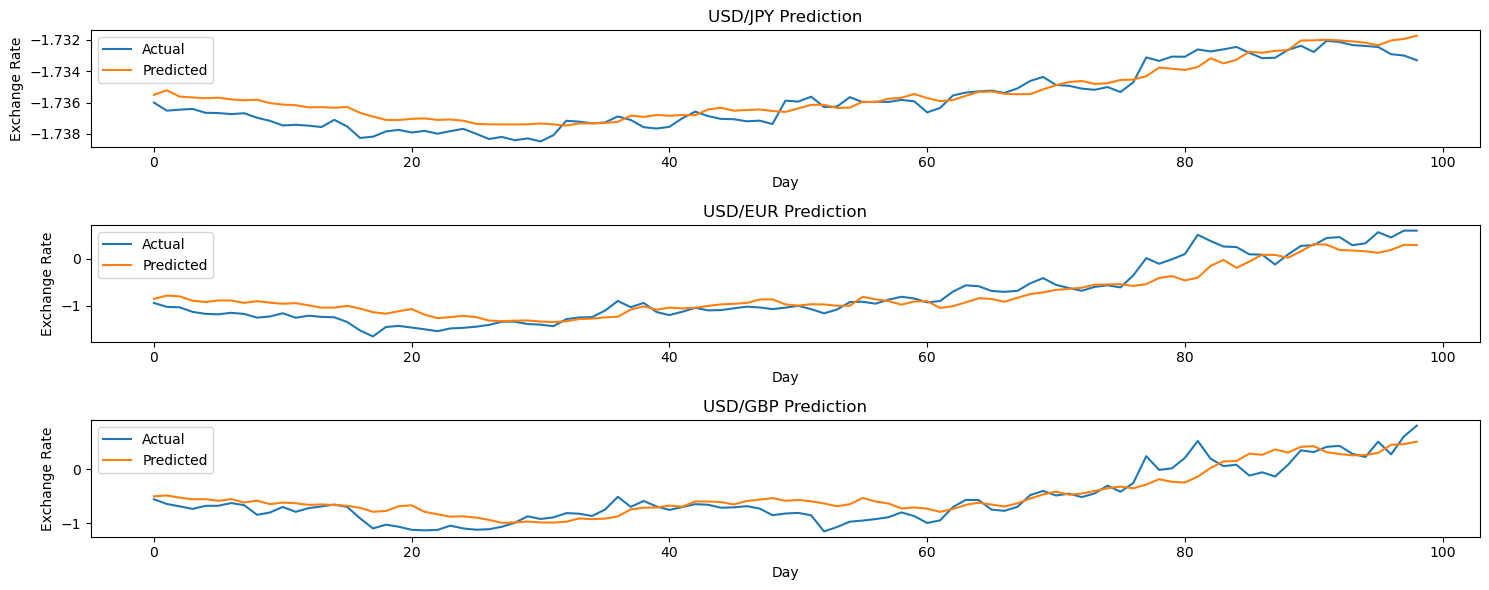

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === 計算 RMSE ===
true_values = scaled_data[601:700] * scaler.scale_ + scaler.min_  # 還原實際值
rmse_list = []

for i in range(3):  # 三種幣別
    rmse = np.sqrt(mean_squared_error(true_values[:, i], predictions[i]))
    rmse_list.append(rmse)
    print(f"RMSE for currency {i+1}: {rmse:.4f}")

# === 畫圖 ===
currency_names = ['USD/JPY', 'USD/EUR', 'USD/GBP']
plt.figure(figsize=(15, 6))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(true_values[:, i], label='Actual')
    plt.plot(predictions[i], label='Predicted')
    plt.title(f'{currency_names[i]} Prediction')
    plt.xlabel('Day')
    plt.ylabel('Exchange Rate')
    plt.legend()

plt.tight_layout()
plt.show()